# Titanic Competition

## Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import style

style.use("fivethirtyeight")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import data

In [2]:
train = pd.read_csv(os.getcwd() + "/data/train.csv")
test = pd.read_csv(os.getcwd() + "/data/test.csv")

## Data exploration

In [3]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [5]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


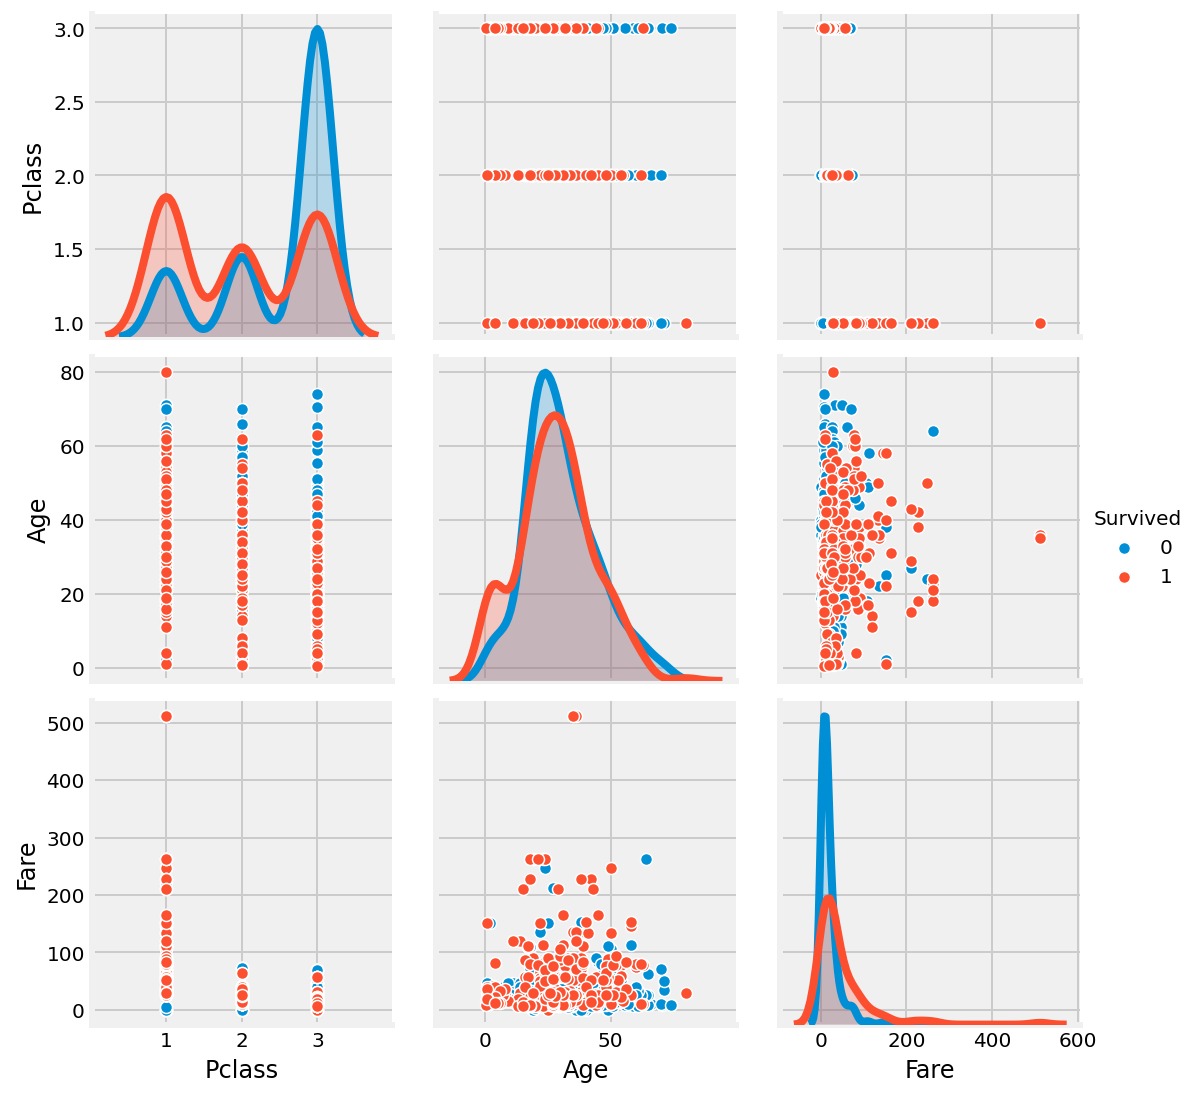

In [6]:
sns.pairplot(train.drop(["PassengerId", "Parch", "SibSp"], axis = 1), hue = "Survived")
plt.show()

In [7]:
def plot(x):
    survived = train[train['Survived'] == 1][x].value_counts()
    dead = train[train['Survived'] == 0][x].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived','Dead']
    df.plot(kind = 'bar', stacked = True, figsize = (10,5))

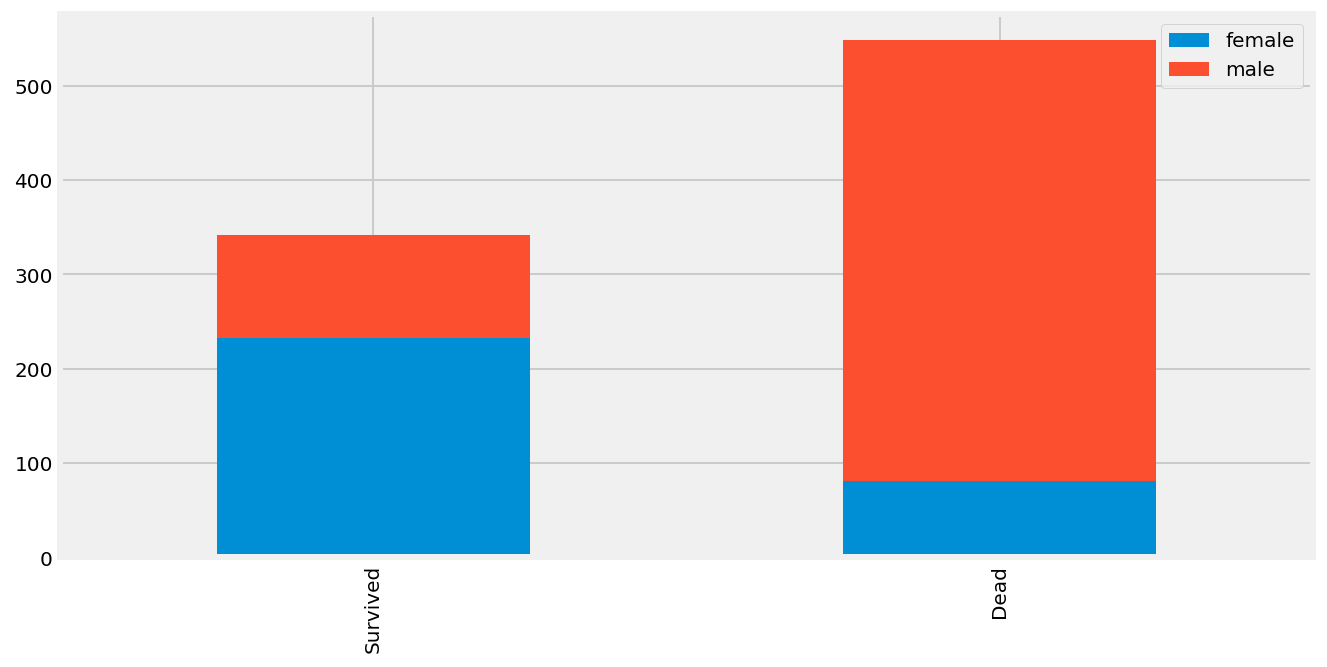

In [8]:
plot("Sex")

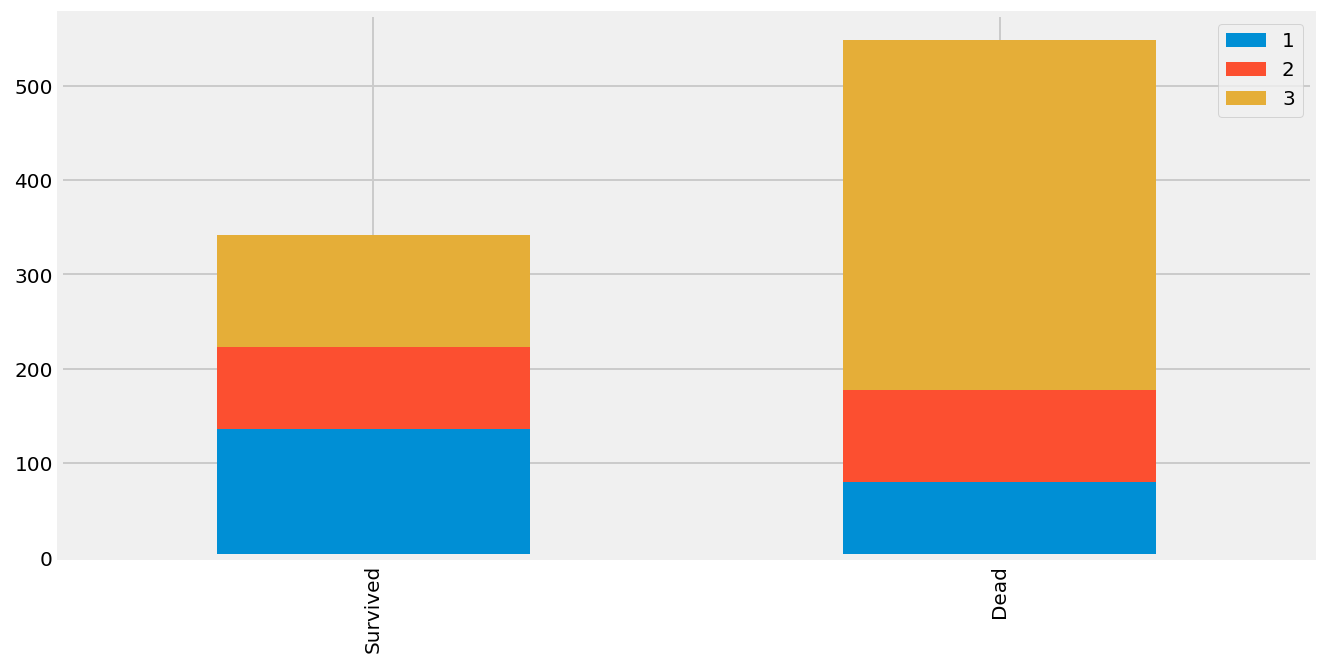

In [9]:
plot("Pclass")

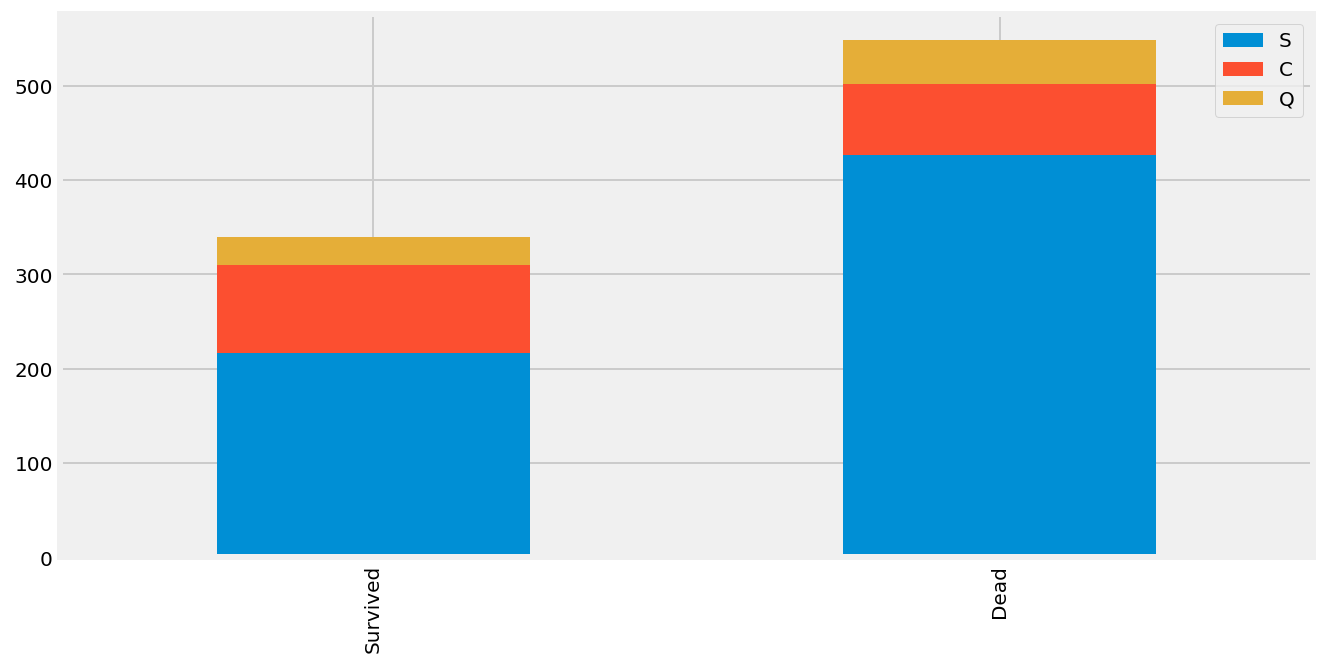

In [10]:
plot("Embarked")

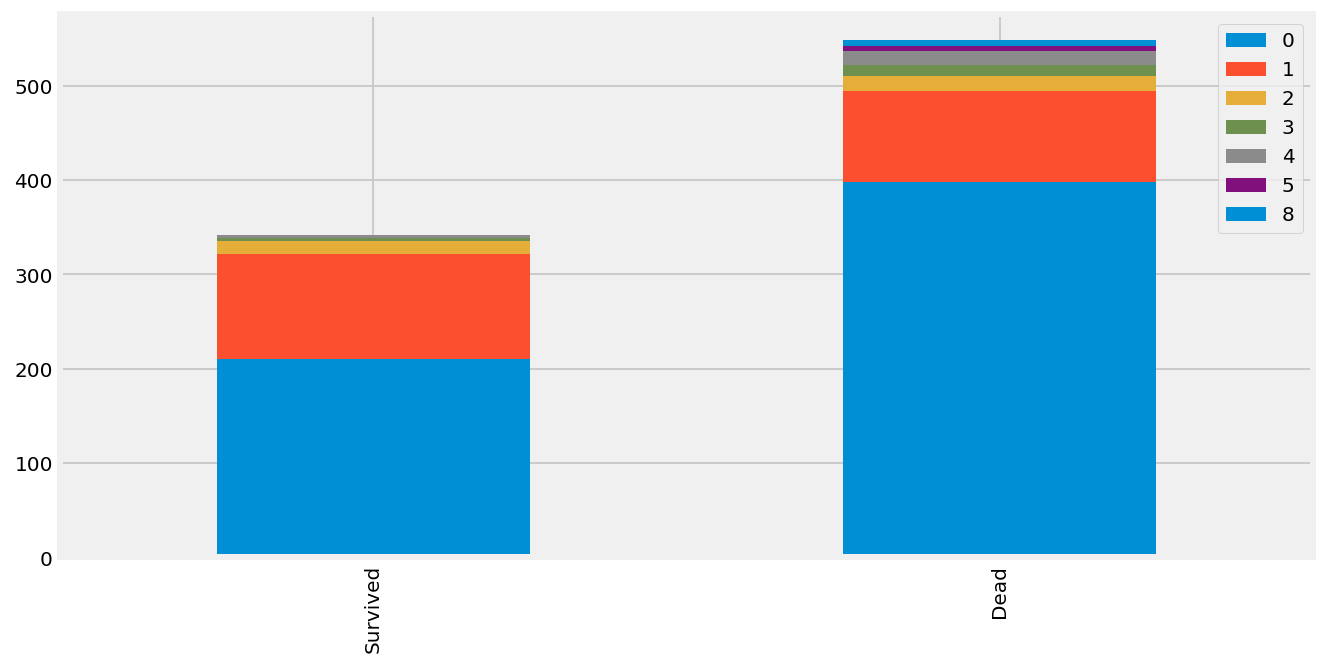

In [11]:
plot("SibSp")

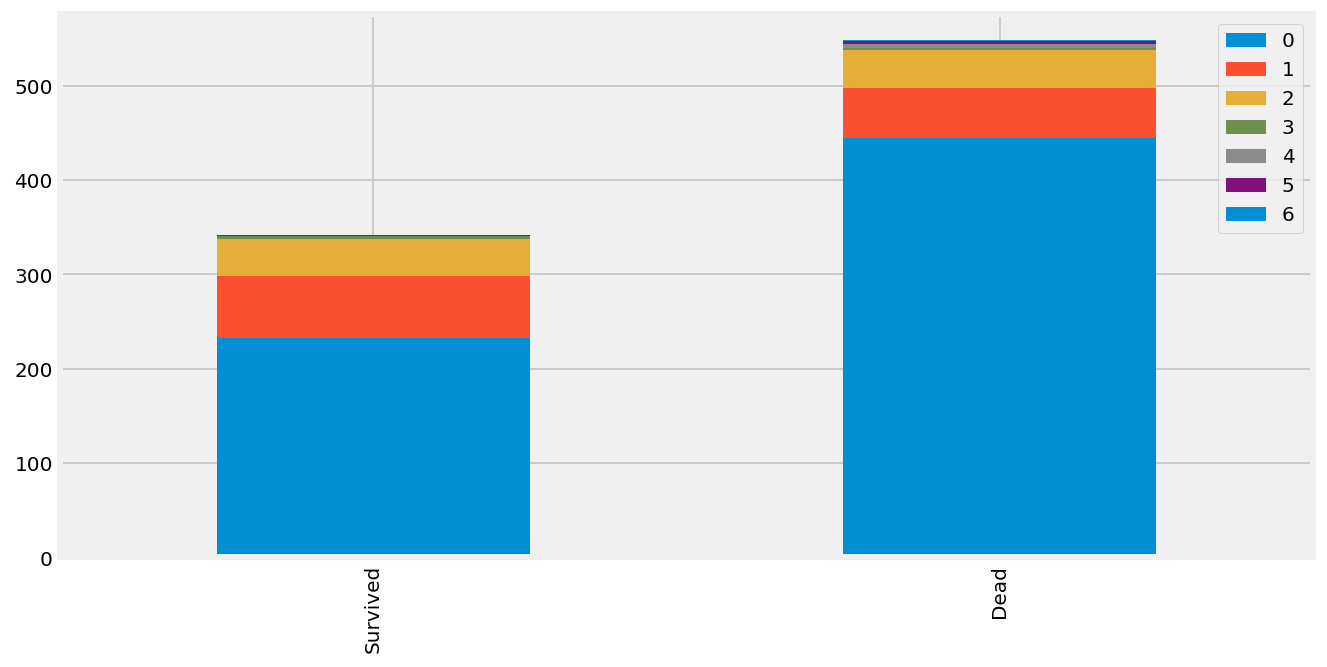

In [12]:
plot("Parch")

## Tidy data

In [13]:
train.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [14]:
train["Age"].fillna(train["Age"].mean(), inplace = True)
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace = True)
train = train.drop(["Name", "Ticket", "Cabin"], axis = 1)

In [15]:
train.isnull().mean()

PassengerId    0.0
Survived       0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Fare           0.0
Embarked       0.0
dtype: float64

In [16]:
test.isnull().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

In [17]:
test["Age"].fillna(test["Age"].mean(), inplace = True)
test["Fare"].fillna(test["Fare"].mean(), inplace = True)
test = test.drop(["Name", "Ticket", "Cabin"], axis = 1)

In [18]:
test.isnull().mean()

PassengerId    0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Fare           0.0
Embarked       0.0
dtype: float64

In [19]:
train = pd.get_dummies(train, columns = ["Sex", "Embarked"])
train.head(1)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.25,0,1,0,0,1


In [20]:
test = pd.get_dummies(test, columns = ["Sex", "Embarked"])
test.head(1)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0,1,0,1,0


In [21]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


## 2-component PCA for visualization

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [23]:
X = train.drop(["PassengerId", "Survived"], axis = 1)
Y = train["Survived"]

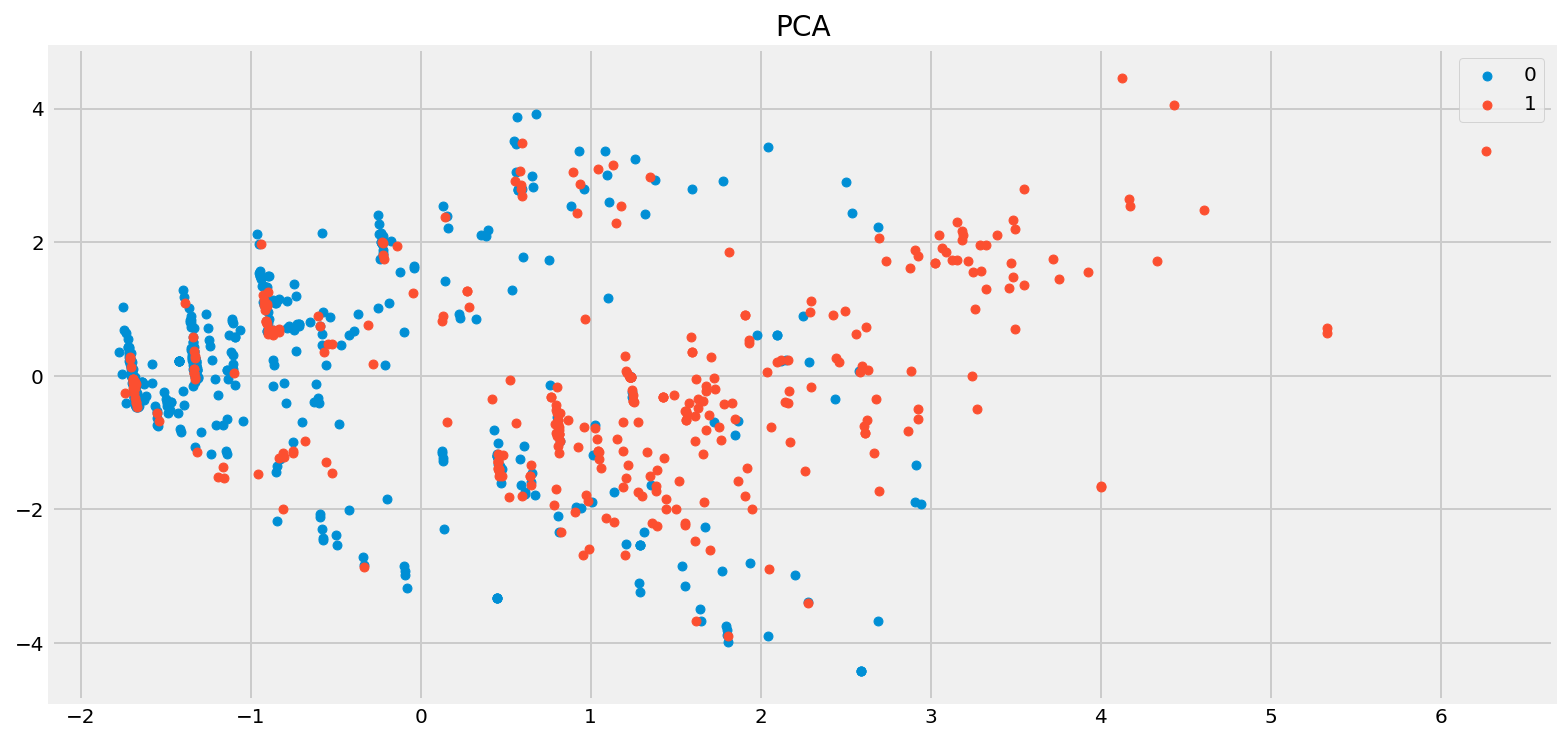

In [24]:
scaler = StandardScaler()
X_pca = scaler.fit_transform(X)

pca = PCA(n_components = 2)
X_pca_transformed = pca.fit_transform(X_pca)

plt.figure(figsize = (12,6))

for i in Y.unique():
    X_pca_filtered = X_pca_transformed[Y == i, :]
    plt.scatter(X_pca_filtered[:, 0], X_pca_filtered[:, 1], s = 20, label = i)
    
plt.legend()
plt.title("PCA", fontsize = 14)
plt.show()

## Machine Learning

In [25]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    random_state = 0, 
                                                    test_size = 0.2)

### Gradient Boosting

In [27]:
clf_boost = GradientBoostingClassifier()

params = {"n_estimators" : [500, 700],
          "learning_rate" : [0.01, 0.05],
          "max_depth" : [5, 7],
          "max_features" : [5, 7]}

gsc_boost = GridSearchCV(clf_boost, params, cv = 5) 
gsc_boost = gsc_boost.fit(X_train, Y_train)

print(gsc_boost.best_estimator_)
clf_boost = gsc_boost.best_estimator_
clf_boost.fit(X_train, Y_train)
print(round(gsc_boost.score(X_test, Y_test), 4))

Y_predicted_boost = clf_boost.predict_proba(X_test)[:, 1]
sub_boost = clf_boost.predict(test.drop(["PassengerId"], axis = 1))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=5,
                           max_features=5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.8492


### Logistic Regression

In [28]:
clf_log = LogisticRegression()

params = {"C" : [0.001, 0.01, 0.1, 1, 1.1, 10],
          "max_iter" : [10000],
          "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}

gsc_log = GridSearchCV(clf_log, params, cv = 5) 
gsc_log = gsc_log.fit(X_train, Y_train)

print(gsc_log.best_estimator_)
clf_log = gsc_log.best_estimator_
clf_log.fit(X_train, Y_train)
print(round(clf_log.score(X_test, Y_test), 4))

Y_predicted_log = clf_log.predict_proba(X_test)[:, 1]
sub_log = clf_log.predict(test.drop(["PassengerId"], axis = 1))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
0.8101


### Decision Tree

In [29]:
clf_tree = DecisionTreeClassifier()

params = {"criterion" : ["gini", "entropy"],
          "max_features" : ["auto", "sqrt", "log2"],
          "max_depth" : [10,20,30,50,100],
          "min_samples_split" : [2,3,5,8,10,13],
          "min_samples_leaf" : [1,5,8]}

gsc_tree = GridSearchCV(clf_tree, params, cv = 5) 
gsc_tree = gsc_tree.fit(X_train, Y_train)

print(gsc_tree.best_estimator_)
clf_tree = gsc_tree.best_estimator_
clf_tree.fit(X_train, Y_train)
print(round(clf_tree.score(X_test, Y_test), 4))

Y_predicted_tree = clf_tree.predict_proba(X_test)[:, 1]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.8212


### Random Forest

In [30]:
clf_rf = RandomForestClassifier()

params = {"criterion" : ["gini", "entropy"],
          "max_features" : ["sqrt", "log2"],
          "max_depth" : [30,50,70],
          "min_samples_split" : [3,5,7],
          "n_estimators" : [200,400,700],
          "min_samples_leaf" : [5,8,10]}

gsc_rf = GridSearchCV(clf_rf, params, cv = 3) 
gsc_rf = gsc_rf.fit(X_train, Y_train)

print(gsc_rf.best_estimator_)
clf_rf = gsc_rf.best_estimator_
clf_rf.fit(X_train, Y_train)
print(round(clf_rf.score(X_test, Y_test), 4))

Y_predicted_rf = clf_rf.predict_proba(X_test)[:, 1]
sub_rf = clf_rf.predict(test.drop(["PassengerId"], axis = 1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.838


### Naive Bayes

In [31]:
clf_nb = GaussianNB()
clf_nb.fit(X_train, Y_train)
print(round(clf_nb.score(X_test, Y_test), 4))

Y_predicted_nb = clf_nb.predict_proba(X_test)[:, 1]

0.7989


### K-Nearest-Neighbor

In [32]:
pipeline = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

params = {"knn__n_neighbors" : [1,3,5,7,9,11,13],
          "knn__algorithm" : ["ball_tree", "kd_tree", "brute", "auto"],
          "knn__weights" : ["uniform", "distance"]}

gsc_knn = GridSearchCV(pipeline, param_grid = params, cv = 5) 
gsc_knn = gsc_knn.fit(X_train, Y_train)

print(gsc_knn.best_estimator_)
clf_knn = gsc_knn.best_estimator_
clf_knn.fit(X_train, Y_train)
print(round(clf_knn.score(X_test, Y_test), 4))

Y_predicted_knn = clf_knn.predict_proba(X_test)[:, 1]
sub_knn = clf_knn.predict(test.drop(["PassengerId"], axis = 1))

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=7, p=2,
                                      weights='uniform'))],
         verbose=False)
0.8212


### SVM

In [33]:
pipeline = Pipeline([("scaler", StandardScaler()), ("svm", SVC(probability = True, kernel = "rbf"))])

params = {"svm__C" : [0.01, 0.1, 1],
          "svm__gamma" : [0.01, 0.1, 1]}

gsc_svm = GridSearchCV(pipeline, param_grid = params, cv = 5) 
gsc_svm = gsc_svm.fit(X_train, Y_train)

print(gsc_svm.best_estimator_)
clf_svm = gsc_svm.best_estimator_
clf_svm.fit(X_train, Y_train)
print(round(clf_svm.score(X_test, Y_test), 4))

Y_predicted_svm = clf_svm.predict_proba(X_test)[:, 1]
sub_svm = clf_svm.predict(test.drop(["PassengerId"], axis = 1))

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.1, kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
0.8101


## ROC-Curve and AUC-Score

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

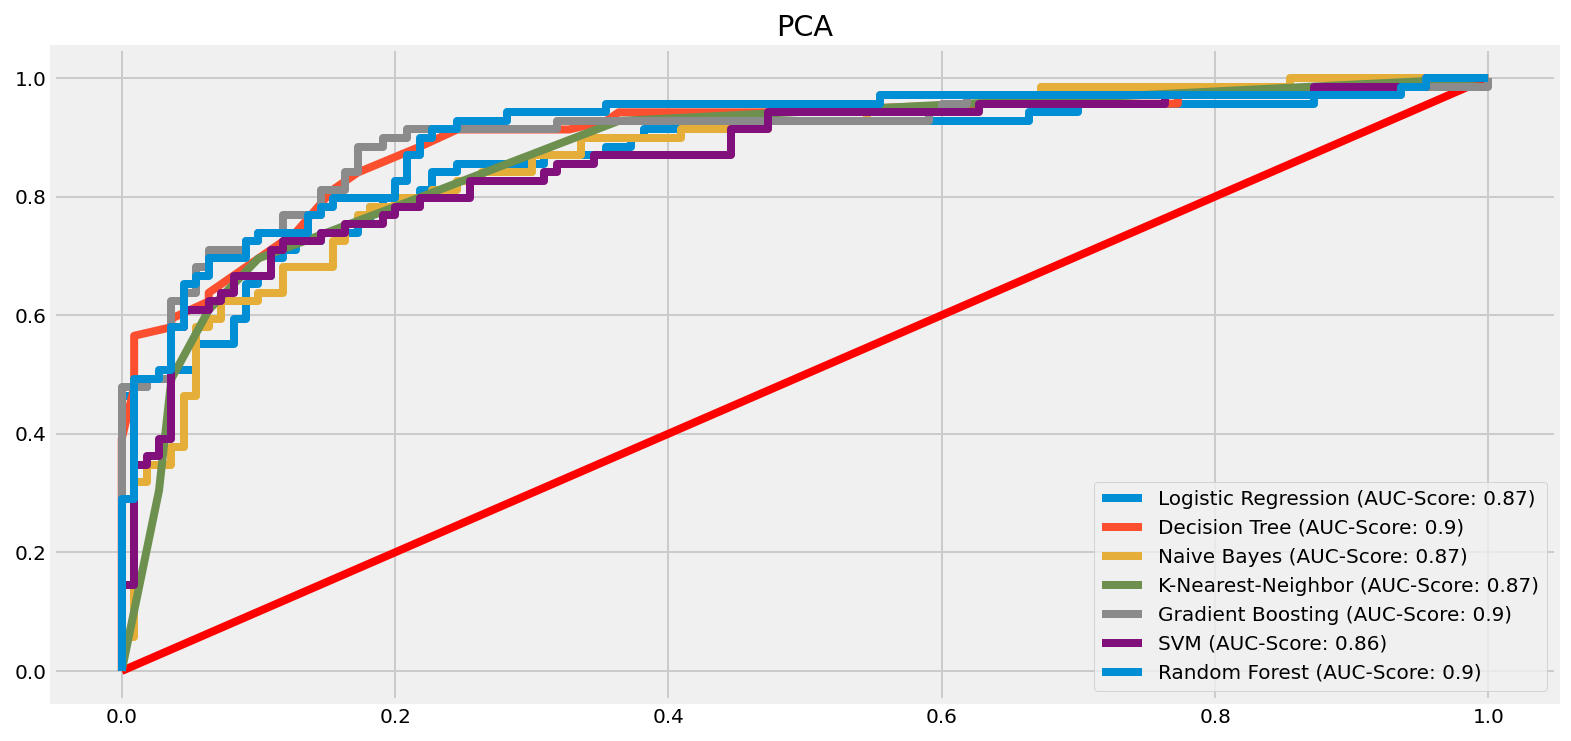

In [38]:
log_fpr, log_tpr, log_treshholds = roc_curve(Y_test, Y_predicted_log)
tree_fpr, tree_tpr, tree_treshholds = roc_curve(Y_test, Y_predicted_tree)
nb_fpr, nb_tpr, nb_treshholds = roc_curve(Y_test, Y_predicted_nb)
knn_fpr, knn_tpr, knn_treshholds = roc_curve(Y_test, Y_predicted_knn)
boost_fpr, boost_tpr, boost_treshholds = roc_curve(Y_test, Y_predicted_boost) 
svm_fpr, svm_tpr, svm_treshholds = roc_curve(Y_test, Y_predicted_svm)
rf_fpr, rf_tpr, rf_treshholds = roc_curve(Y_test, Y_predicted_rf)

auc_score_log = roc_auc_score(Y_test, Y_predicted_log)
auc_score_tree = roc_auc_score(Y_test, Y_predicted_tree)
auc_score_nb = roc_auc_score(Y_test, Y_predicted_nb)
auc_score_knn = roc_auc_score(Y_test, Y_predicted_knn)
auc_score_boost = roc_auc_score(Y_test, Y_predicted_boost)
auc_score_svm = roc_auc_score(Y_test, Y_predicted_svm)
auc_score_rf = roc_auc_score(Y_test, Y_predicted_rf)

plt.figure(figsize = (12,6))
plt.plot([0,1], [0,1], color = "red")
plt.plot(log_fpr, log_tpr, label = "Logistic Regression (AUC-Score: " + str(round(auc_score_log, 2)) + ")")
plt.plot(tree_fpr, tree_tpr, label = "Decision Tree (AUC-Score: " + str(round(auc_score_tree, 2)) + ")")
plt.plot(nb_fpr, nb_tpr, label = "Naive Bayes (AUC-Score: " + str(round(auc_score_nb, 2)) + ")")
plt.plot(knn_fpr, knn_tpr, label = "K-Nearest-Neighbor (AUC-Score: " + str(round(auc_score_knn, 2)) + ")")
plt.plot(boost_fpr, boost_tpr, label = "Gradient Boosting (AUC-Score: " + str(round(auc_score_boost, 2)) + ")")
plt.plot(svm_fpr, svm_tpr, label = "SVM (AUC-Score: " + str(round(auc_score_svm, 2)) + ")")
plt.plot(rf_fpr, rf_tpr, label = "Random Forest (AUC-Score: " + str(round(auc_score_rf, 2)) + ")")
plt.title("PCA")
plt.legend()
plt.show()

## Submission to Kaggle

In [ ]:
submission_log = pd.DataFrame({"PassengerId" : test.PassengerId, 
                               "Survived" : sub_log})

submission_log.to_csv("submission_log", index = False)

In [ ]:
submission_knn = pd.DataFrame({"PassengerId" : test.PassengerId, 
                               "Survived" : sub_knn})

submission_knn.to_csv("submission_knn", index = False)

In [ ]:
submission_boost = pd.DataFrame({"PassengerId" : test.PassengerId, 
                               "Survived" : sub_boost})

submission_boost.to_csv("submission_boost", index = False)

In [ ]:
submission_svm = pd.DataFrame({"PassengerId" : test.PassengerId, 
                               "Survived" : sub_svm})

submission_svm.to_csv("submission_svm", index = False)

In [ ]:
submission_rf = pd.DataFrame({"PassengerId" : test.PassengerId, 
                               "Survived" : sub_rf})

submission_rf.to_csv("submission_rf", index = False)